### Installing the important libraries


In [15]:
"""
conda install -c conda-forge swig -y
conda install -c conda-forge box2d-py -y
python -m pip install --upgrade pip setuptools wheel
python -m pip install gymnasium[box2d]
"""

'\nconda install -c conda-forge swig -y\nconda install -c conda-forge box2d-py -y\npython -m pip install --upgrade pip setuptools wheel\npython -m pip install gymnasium[box2d]\n'

### Importing the important modules

It is preferred to train the model on a device with a GPU

In [16]:
import gymnasium as gym
import matplotlib
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import torch
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
from itertools import count
import random
import math
import pickle
import os
from datetime import datetime

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Implementation of the Car Racing game from Gymnasium using Deep Q Learning with CNN

https://gymnasium.farama.org/environments/box2d/car_racing/#


# Understanding Deep Q-Networks (DQN)

**Deep Q-Network (DQN)** is a landmark Reinforcement Learning (RL) algorithm pioneered by DeepMind in 2013. It was the first method to successfully combine traditional **Q-Learning** with **Deep Neural Networks**, enabling AI to master complex tasks directly from high-dimensional sensory input, such as raw pixels.

In simple terms:
* **Q-Learning**: The mathematical logic used to find the best action to take in any given state.
* **Deep Learning**: The "eyes" and "memory" that process images and approximate complex values.


## How DQN Works: The Core Components

DQN functions by estimating the **Q-value** (Quality value) for every possible action in a given state. The Q-value represents the total expected reward an agent will receive starting from that state and following its policy until the end of the episode.

### 1. The Function Approximator (The "Brain")
In traditional Q-learning, a table is used to store values for every state-action pair. However, in environments like `CarRacing-v3`, there are billions of possible pixel combinations, making a table impossible. DQN uses a **Convolutional Neural Network (CNN)** to look at the screen and predict the Q-values for discrete actions such as "Accelerate," "Brake," or "Turn".



### 2. Experience Replay
To learn effectively, the agent stores its past experiences—$(state, action, reward, next\_state)$—in a **Replay Memory**.
* Instead of learning only from the most recent action (which is often highly repetitive), the agent "replays" random batches of past experiences.
* This process breaks the correlation between consecutive frames, making the training process much more stable.

### 3. The Target Network
DQN utilizes two separate networks to stabilize training: the **Policy Network** and the **Target Network**.
* If a single network were used to both predict values and update them, the "goalposts" would constantly move, leading to mathematical instability.
* The **Target Network** provides a stable "ground truth" for a short period. Its weights are synchronized with the Policy Network only every few hundred steps.

### 4. The Bellman Equation
The mathematical heart of DQN is the **Bellman Equation**. The network weights are updated so that the current prediction $Q(s, a)$ moves closer to the target:

$$Q(s, a) \approx r + \gamma \max_{a'} Q(s', a')$$

**Where:**
* $r$: The immediate reward.
* $\gamma$ (gamma): The discount factor, determining how much the agent cares about future rewards.
* $\max_{a'} Q(s', a')$: The best predicted value for the next state.



### 5. Exploration vs. Exploitation ($\epsilon$-greedy)
The agent must balance discovering new strategies with using what it already knows:
* **Exploration**: Early in training, the agent takes random actions to explore the environment.
* **Exploitation**: As it learns, it begins to choose actions with the highest predicted Q-values.
* This is managed by the **Epsilon ($\epsilon$)** parameter, which typically starts high and "decays" (decreases) over time.

---

## 1. Setup and Preprocessing

### Observation Space:
- A top-down 96x96 RGB image of the car and race track.

To make learning efficient, we can't just throw raw RGB frames at the network. The following section handles State Representation:

- **Preprocessing:** We convert images to grayscale and resize them to $84 \times 84$ to reduce the computational load.
- **Frame Skipping:** The agent doesn't need to see every single frame to understand movement. We skip frames to speed up training.
- **Frame Stacking:** A single static image doesn't show velocity. By stacking the 4 most recent frames, we provide the network with temporal context (motion).

In [17]:
def image_preprocessing(img):
  img = cv2.resize(img, dsize=(84, 84))
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) / 255.0
  return img

Set up the Environment Wrapper

In [18]:
class CarEnvironment(gym.Wrapper):
  def __init__(self, env, skip_frames=3, stack_frames=4, no_operation=50, **kwargs):
    super().__init__(env, **kwargs)
    self._no_operation = no_operation
    self._skip_frames = skip_frames # We choose an action and repeat it for N (4) frames
    self._stack_frames = stack_frames # We stack N (4) frames to be able to infer velocity information

  def reset(self):
    observation, info = self.env.reset()

    for i in range(self._no_operation):
      observation, reward, terminated, truncated, info = self.env.step(0)

    observation = image_preprocessing(observation)
    self.stack_state = np.tile(observation, (self._stack_frames, 1, 1))
    return self.stack_state, info


  def step(self, action):
    total_reward = 0
    for i in range(self._skip_frames):
      observation, reward, terminated, truncated, info = self.env.step(action)
      total_reward += reward
      if terminated or truncated:
        break

    observation = image_preprocessing(observation)
    self.stack_state = np.concatenate((self.stack_state[1:], observation[np.newaxis]), axis=0)
    return self.stack_state, total_reward, terminated, truncated, info


## 2. The Brain: Convolutional Neural Network (CNN)

Standard Q-Learning uses a table to store values, but our state space is too vast for that. Instead, we use a Function Approximator: a CNN.

- The Convolutional Layers act as feature extractors, identifying the edges of the track and the car's position.

- The Fully Connected Layers map these visual features to Q-values for each of the 5 possible discrete actions (e.g., steer left, accelerate, brake).

### Action Space
If continuous there are 3 actions :

    0: steering, (-1 is full left, +1 is full right)
    1: gas
    2: braking

If discrete there are 5 actions:

    0: do nothing
    1: steer right
    2: steer left
    3: gas
    4: brake

In [19]:
class CNN(nn.Module):
  def __init__(self, in_channels, out_channels, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self._n_features = 32 * 9 * 9

    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, 16, kernel_size=8, stride=4),
        nn.ReLU(),
        nn.Conv2d(16, 32, kernel_size=4, stride=2),
        nn.ReLU(),
    )

    self.fc = nn.Sequential(
        nn.Linear(self._n_features, 256),
        nn.ReLU(),
        nn.Linear(256, out_channels),
    )


  def forward(self, x):
    x = self.conv(x)
    x = x.view((-1, self._n_features))
    x = self.fc(x)
    return x

## 3. Stabilizing Learning: Replay Memory

One major challenge in RL is that consecutive experiences are highly correlated (e.g., if you are turning left now, you are likely still turning left in the next frame). This breaks the "Independent and Identically Distributed" (IID) assumption required for neural network training.
- We use Experience Replay to store transitions $(s, a, s', r)$ in a buffer.
- During training, we sample random batches, which breaks the correlation between samples and leads to more stable convergence.

In [20]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## 4. The DQN Algorithm Logic
This is the core of the agent, it is the function responsible for selecting an action based on the observation state. It implements two critical DQN features:
1. **Epsilon-Greedy Strategy:** To balance Exploration (trying new things) and Exploitation (using what we know). Notice how eps_threshold decays over time.
2. **Target Network:** To prevent the "moving target" problem, we use two identical networks. The network is updated every step, while the target_network stays fixed and is only updated every $C$ steps to provide stable ground-truth labels.

In [ ]:
class DQN:
  def __init__(self, action_space, batch_size=256, gamma=0.99, eps_start=0.9, eps_end=0.05, eps_decay=1000, lr=0.001):
    self._n_observation = 4 # Stacked frames
    self._n_actions = 5 # Possible discretized actions
    self._action_space = action_space
    self._batch_size = batch_size # Batch size for training: Higher batch size means more stable training but requires more memory
    self._gamma = gamma # Discount factor for future rewards. The closer to 1 it is, the more the agent will consider future rewards
    self._eps_start = eps_start # Initial exploration probability
    self._eps_end = eps_end # Final exploration probability
    self._eps_decay = eps_decay # Decay rate for exploration probability
    self._lr = lr # Learning rate for the optimizer: Higher learning rate means faster learning but can lead to instability
    self._total_steps = 0
    self._evaluate_loss = []
    self.network = CNN(self._n_observation, self._n_actions).to(device) # Policy network
    self.target_network = CNN(self._n_observation, self._n_actions).to(device) # Target network
    self.target_network.load_state_dict(self.network.state_dict())
    self.optimizer = optim.AdamW(self.network.parameters(), lr=self._lr, amsgrad=True)
    self._memory = ReplayMemory(10000)

  """
  This function is called during training & evaluation phase when the agent
  interact with the environment and needs to select an action.

  (1) Exploitation: This function feeds the neural network a state
  and then it selects the action with the highest Q-value.
  (2) Evaluation mode: This function feeds the neural network a state
  and then it selects the action with the highest Q'-value.
  (3) Exploration mode: It randomly selects an action through sampling

  Q -> network (policy)
  Q'-> target network (best policy)
  """
  def select_action(self, state, evaluation_phase=False):

    # Generating a random number for eploration vs exploitation
    sample = random.random()

    # Calculating the threshold - the more steps the less exploration we do
    eps_threshold = self._eps_end + (self._eps_start - self._eps_end) * math.exp(-1. * self._total_steps / self._eps_decay)
    self._total_steps += 1

    if evaluation_phase:
      with torch.no_grad():
        return self.target_network(state).max(1).indices.view(1, 1)
    elif sample > eps_threshold:
      with torch.no_grad():
        return self.network(state).max(1).indices.view(1, 1)
    else:
      return torch.tensor([[self._action_space.sample()]], device=device, dtype=torch.long)

  """
  This function trains the agent
  """
  def train(self):

    if len(self._memory) < self._batch_size:
        return

    # Initializing our memory
    transitions = self._memory.sample(self._batch_size)

    # Initializing our batch
    batch = Transition(*zip(*transitions))

    # Saving in a new tensor all the indices of the states that are non terminal
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)

    # Saving in a new tensor all the non final next states
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Feeding our Q network the batch with states and then we gather the Q values of the selected actions
    state_action_values = self.network(state_batch).gather(1, action_batch)

    # We then, for every state in the batch that is NOT final, we pass it in the target network to get the Q'-values and choose the max one
    next_state_values = torch.zeros(self._batch_size, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = self.target_network(non_final_next_states).max(1).values

    # Computing the expecting values with: reward + gamma * max(Q')
    expected_state_action_values = (next_state_values * self._gamma) + reward_batch

    # Defining our loss criterion
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Updating with back propagation
    self.optimizer.zero_grad()
    loss.backward()

    torch.nn.utils.clip_grad_value_(self.network.parameters(), 100)
    self.optimizer.step()

    self._evaluate_loss.append(loss.item())

    return

  def copy_weights(self):
    self.target_network.load_state_dict(self.network.state_dict())

  def get_loss(self):
    return self._evaluate_loss

  def save_model(self, i):
    os.makedirs('DQN_model_weights', exist_ok=True)
    torch.save(self.target_network.state_dict(), f'DQN_model_weights/model_weights_{i}.pth')
    path = f'DQN_model_weights/model_weights_{i}.pth'

  def load_model(self, i):
    path = f'DQN_model_weights/model_weights_{i}.pth'
    legacy = f'model_weights_{i}.pth'

    # Try the current path first
    if os.path.exists(path):
      self.target_network.load_state_dict(torch.load(path, map_location=device))
      return

    # Then try the legacy filename in cwd
    if os.path.exists(legacy):
      self.target_network.load_state_dict(torch.load(legacy, map_location=device))
      return

    # If neither exists, raise
    raise FileNotFoundError(f'Could not find model file {path} or {legacy}')

## 5. The Training Loop

This is where everything comes together. For every step in the environment:
1. The agent selects an action.
2. The environment returns a new state and reward.
3. The transition is saved to memory.
4. We perform a Gradient Descent step using the loss between our current Q-prediction and the target Q-value (calculated using the Bellman Equation).$$\text{Loss} = Q(s, a) - (r + \gamma \max_{a'} Q_{target}(s', a'))$$

In [22]:
rewards_per_episode = []
episode_duration = []
average_episode_loss = []

episodes = 1000
C = 5

env = gym.make('CarRacing-v3', continuous=False)
n_actions = env.action_space
agent = DQN(n_actions)

for episode in range(1, episodes + 1):

  if episode % 10 == 0:
    print(f"{episode} episodes done")

  env = gym.make('CarRacing-v3', continuous=False)
  env = CarEnvironment(env)

  state, info = env.reset()

  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

  episode_total_reward = 0.0

  for t in count():
    action = agent.select_action(state)
    observation, reward, terminated, truncated, _ = env.step(action.item())
    reward = torch.tensor([reward], device=device)
    episode_total_reward += reward.item()
    done = terminated or truncated

    if terminated:
      next_state = None
      print("Finished the lap successfully!")
    else:
      next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

    agent._memory.push(state, action, next_state, reward)

    state = next_state

    agent.train()

    if done:
      if agent._memory.__len__() >= 128:
        episode_duration.append(t + 1)
        rewards_per_episode.append(episode_total_reward)
        ll = agent.get_loss()
        average_episode_loss.append(sum(ll) / len(ll))
      break

    if episode % 100 == 0:
      agent.save_model(episode)
      with open('statistics.pkl', 'wb') as f:
        pickle.dump((episode_duration, rewards_per_episode, average_episode_loss), f)


  if episode % C == 0:
    agent.copy_weights()

agent.save_model(episodes)
with open('statistics.pkl', 'wb') as f:
  pickle.dump((episode_duration, rewards_per_episode, average_episode_loss), f)

/opt/miniconda3/envs/rl_gymnasium/lib/python3.11/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


10 episodes done
20 episodes done
30 episodes done
Finished the lap successfully!
40 episodes done
Finished the lap successfully!
50 episodes done
Finished the lap successfully!
Finished the lap successfully!
60 episodes done
Finished the lap successfully!
70 episodes done
80 episodes done
90 episodes done
100 episodes done
110 episodes done
120 episodes done
130 episodes done
140 episodes done
Finished the lap successfully!
150 episodes done
160 episodes done
170 episodes done
180 episodes done
190 episodes done
200 episodes done
210 episodes done
Finished the lap successfully!
Finished the lap successfully!
220 episodes done
Finished the lap successfully!
230 episodes done
240 episodes done
250 episodes done
260 episodes done
Finished the lap successfully!
270 episodes done
Finished the lap successfully!
Finished the lap successfully!
280 episodes done
Finished the lap successfully!
290 episodes done
300 episodes done
Finished the lap successfully!
Finished the lap successfully!
310 

# Evaluation of the agent


Training an agent is useless if we can't verify its performance. Here, we:

- Plot Rewards: To see if the agent is learning to stay on the track longer.

- Plot Loss: To monitor the stability of the neural network's convergence.

- Render Video: To visually inspect the agent's "driving style."

In [23]:
def plot_statistics(x, y, title, x_axis, y_axis):
  plt.plot(x, y)
  plt.xlabel(x_axis)
  plt.ylabel(y_axis)
  plt.title(title)
  plt.grid(True)
  plt.savefig(f'{title}.png')
  plt.show()

In [24]:
eval_env = gym.make('CarRacing-v3', continuous=False, render_mode='rgb_array')
eval_env = CarEnvironment(eval_env)

frames = []
scores = 0
s, _ = eval_env.reset()

eval_env.np_random = np.random.default_rng(42)

done, ret = False, 0

while not done:
    frames.append(eval_env.render())
    s = torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0)
    a = agent.select_action(s, evaluation_phase=True)
    discrete_action = a.item() % 5
    s_prime, r, terminated, truncated, info = eval_env.step(discrete_action)
    s = s_prime
    ret += r
    done = terminated or truncated
    if terminated:
      print(terminated)
scores += ret


def animate(imgs, video_name, _return=True):
    import cv2
    import os
    import string
    import random

    if video_name is None:
        video_name = ''.join(random.choice(string.ascii_letters) for i in range(18)) + '.webm'
    height, width, layers = imgs[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'VP90')
    video = cv2.VideoWriter(video_name, fourcc, 10, (width, height))

    for img in imgs:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        video.write(img)
    video.release()

True


OpenCV: FFMPEG: tag 0x30395056/'VP90' is not supported with codec id 167 and format 'webm / WebM'


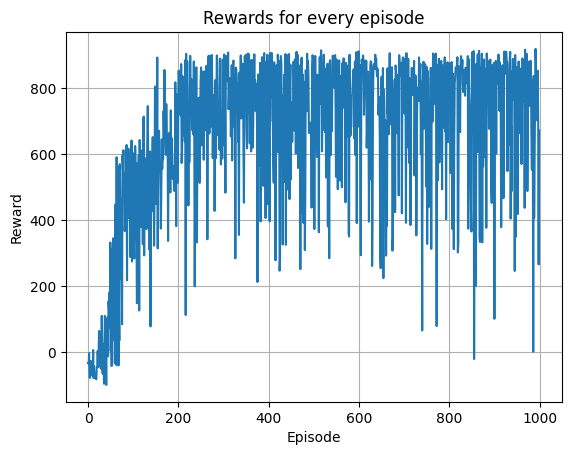

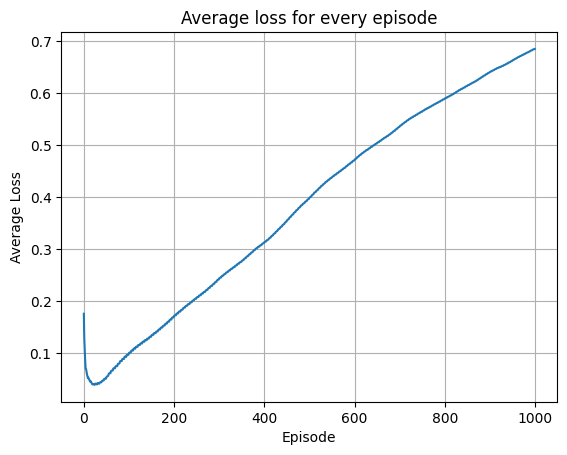

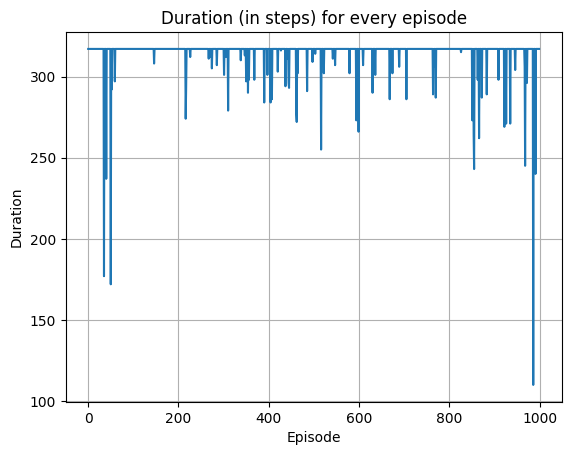

In [25]:
animate(frames, None)

with open('statistics.pkl', 'rb') as f:
    data_tuple = pickle.load(f)

episode_duration, rewards_per_episode, average_episode_loss = data_tuple

plot_statistics(list(range(len(rewards_per_episode))), rewards_per_episode, "Rewards for every episode", "Episode", "Reward")
plot_statistics(list(range(len(average_episode_loss))), average_episode_loss, "Average loss for every episode", "Episode", "Average Loss")
plot_statistics(list(range(len(episode_duration))), episode_duration, "Duration (in steps) for every episode", "Episode", "Duration")

In [28]:
# Quick test for save/load
class _DummyActionSpace:
    def sample(self):
        return 0

agent_test = DQN(_DummyActionSpace())
# Save model (creates directory if missing)
agent_test.save_model(0)
import os
print('Saved path exists:', os.path.exists('model_weights/model_weights_0.pth'))
# Load back to verify
agent_test.load_model(0)
print('Load succeeded')
# Cleanup the created file for the test (optional)
try:
    os.remove('model_weights/model_weights_0.pth')
except Exception:
    pass


Saved path exists: True
Load succeeded
